Script originally based on
https://www.kaggle.com/code/philculliton/inferring-birds-with-kaggle-models


In [1]:
import glob
import importlib
import math
import os
import pickle

import keras
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from IPython.display import Audio

tf.keras.utils.set_random_seed(42)

import preprocessing
import constants
from birddata import data
from birdmodeling import fftlayer, spectrogram_model
from birdtraining import callbacks, metrics, tuning

2024-11-20 17:21:48.097632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 17:21:48.839075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-20 17:21:50.234688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-20 17:21:50.270084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

# Data characteristics
- Number of classes
- Number of recordings per class
- Length of recordings
- Spectrograms for eight of the classes

In [2]:
metadata = data.Data(os.path.join(constants.base_dir, constants.metadata_csv))

NUM_CLASSES 264


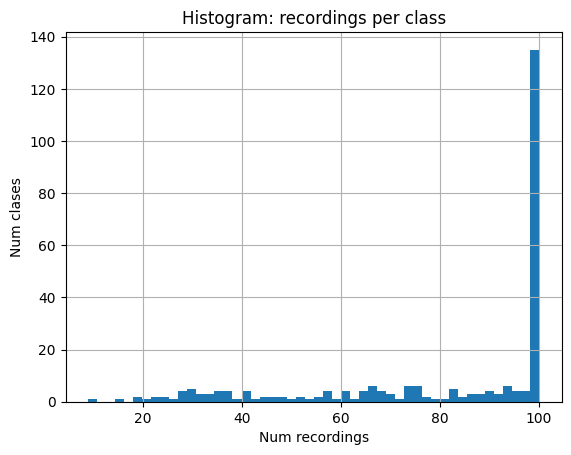

In [3]:
label_counts = metadata.df.groupby('primary_label').count()['filename']
ax = label_counts.hist(bins=50);
ax.set_title("Histogram: recordings per class")
ax.set_xlabel("Num recordings")
ax.set_ylabel("Num clases");

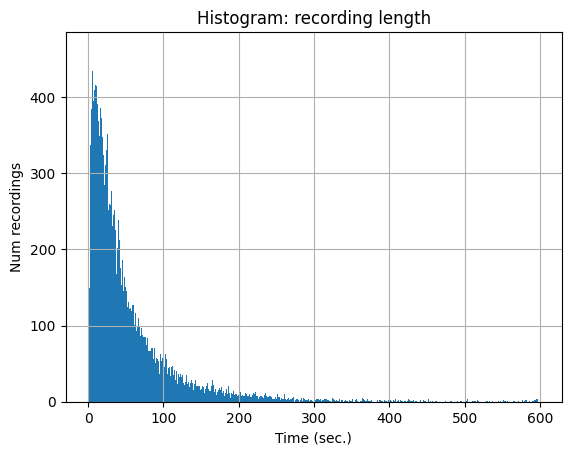

In [4]:
if 'duration' in metadata.df.columns:
    ax = metadata.df['duration'].hist(bins=range(600))
    ax.set_title("Histogram: recording length")
    ax.set_xlabel("Time (sec.)")
    ax.set_ylabel("Num recordings")

In [5]:
def display_sample_fft(df, group_id=0):
    group_size = 8
    fig, axs = plt.subplots( math.ceil(group_size/4), 4, figsize=(200,50))
    df = df[ df['duration'] >= 5.]

    for ax, (idx, row) in zip(axs.flatten(), df.groupby('primary_label').sample(n=1)[group_id*group_size:].iterrows()):
        print(row.filename)
        sample_audio = preprocessing.load_audio(row.full_path)
        sample_fft = fftlayer.FFT()(sample_audio)
        sample_fft = sample_fft[:299, :, 0]
        ax.imshow(tf.transpose(sample_fft))
        ax.invert_yaxis()
        ax.set_title(row.primary_label, fontsize=100)

In [6]:
display_sample_fft(metadata.df)

aldfly/XC247799.ogg


2024-11-20 17:22:07.067234: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 FMA
2024-11-20 17:22:07.396226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


CALL False
ameavo/XC324505.ogg
CALL False
amebit/XC298966.ogg
CALL False
amecro/XC172881.ogg
CALL False
amegfi/XC315598.ogg
CALL False
amekes/XC56416.ogg
CALL False
amepip/XC51412.ogg
CALL False
amered/XC391157.ogg
CALL False


# Preprocessing
- Visualize using two recordings from 'abethr1' class (African bare-eyed thrush)
  - Unmodified recordings
  - Not Shown: Chop beginning of audio
  - (Circular) shift (of first recording)
  - Combination of both recordings
  - Splitting into 5 second frames (pad/replicate, as necessary, to get 12 frames)
  - Spectrograms (of both individual recording and of combined recording)

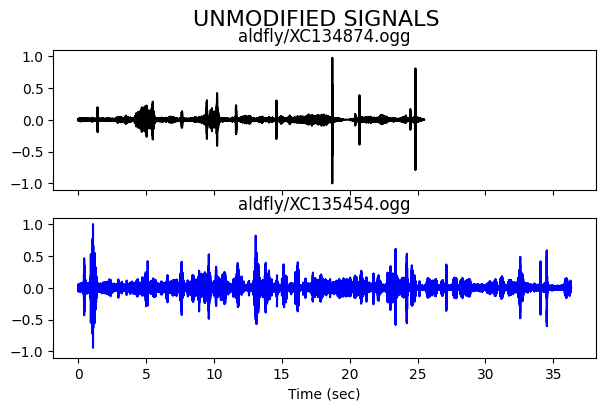

In [7]:
sample_fullpath0, sample_fn0, sample_index0, sample_label0 = metadata.df[['full_path', 'filename', 'primary_index', 'primary_label']].loc[0].tolist()
sample_fullpath1, sample_fn1, sample_index1, sample_label1 = metadata.df[['full_path', 'filename', 'primary_index', 'primary_label']].loc[1].tolist()
# assert sample_label0 == 'abethr1' and sample_label1 == 'abethr1'
sample_audio0 = preprocessing.load_audio(sample_fullpath0)
sample_audio1 = preprocessing.load_audio(sample_fullpath1)

fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(7, 4))
fig.suptitle('UNMODIFIED SIGNALS', size=16)
axs[0].plot([x/constants.model_sr for x in range(len(sample_audio0))], sample_audio0, 'k')
axs[1].plot([x/constants.model_sr for x in range(len(sample_audio1))], sample_audio1, 'b')
axs[0].set_title(sample_fn0)
axs[1].set_title(sample_fn1)
axs[1].set_xlabel('Time (sec)');

In [8]:
Audio(sample_audio0, rate=constants.model_sr)

In [9]:
Audio(sample_audio1, rate=constants.model_sr)

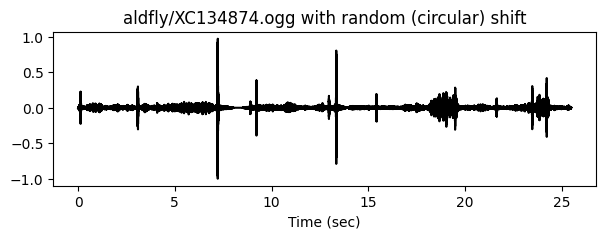

In [10]:
sample_shift0, _ = preprocessing.shift_audio(sample_audio0, sample_index1)

fig, axs = plt.subplots(1,1, figsize=(7, 2))
axs.plot([x/constants.model_sr for x in range(len(sample_shift0))], sample_shift0, 'k')
axs.set_title(f'{sample_fn0} with random (circular) shift')
axs.set_xlabel('Time (sec)');

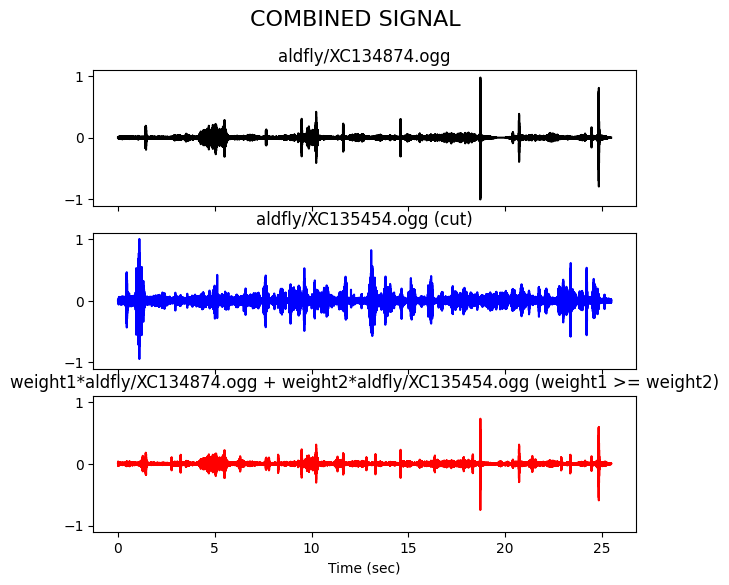

In [11]:
simple_files_for_combining = [[]] * metadata.num_classes
simple_files_for_combining[sample_index1] = [sample_fullpath1]
sample_audio1_cut = preprocessing.match_lengths(sample_audio0, sample_audio1)
sample_combine, _ = preprocessing.combine_recordings(sample_audio0, sample_index0, simple_files_for_combining, weight=0.75)

fig, axs = plt.subplots(3,1, figsize=(7, 6), sharex=True, sharey=True)
fig.suptitle('COMBINED SIGNAL', size=16)
axs[0].plot([x/constants.model_sr for x in range(len(sample_audio0))], sample_audio0, 'k')
axs[0].set_title(sample_fn0)
axs[1].plot([x/constants.model_sr for x in range(len(sample_audio1_cut))], sample_audio1_cut, 'b')
# for x in range(1, 3):
#     axs[1].axvline(x*len(sample_audio1)/constants.model_sr)
axs[1].set_title(sample_fn1 + ' (cut)')
axs[2].plot([x/constants.model_sr for x in range(len(sample_combine))], sample_combine, 'r')
axs[2].set_title(f'weight1*{sample_fn0} + weight2*{sample_fn1} (weight1 >= weight2)')
axs[2].set_xlabel('Time (sec)');

(6, 110250)


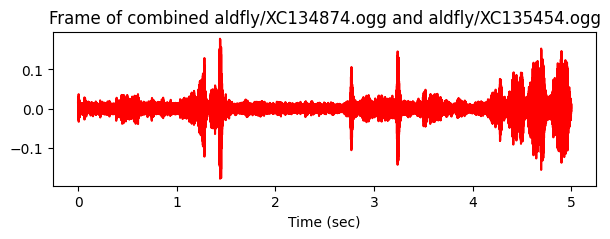

In [12]:
sample_framed, _  = preprocessing.frame_audio(sample_combine, sample_index0)
print(sample_framed.shape)
fig, axs = plt.subplots(1, 1, figsize=(7, 2), )
axs.plot([x/constants.model_sr for x in range(len(sample_framed[0]))], sample_framed[0], 'r')
axs.set_title(f'Frame of combined {sample_fn0} and {sample_fn1}')
axs.set_xlabel('Time (sec)');

CALL True
CALL False
CALL False


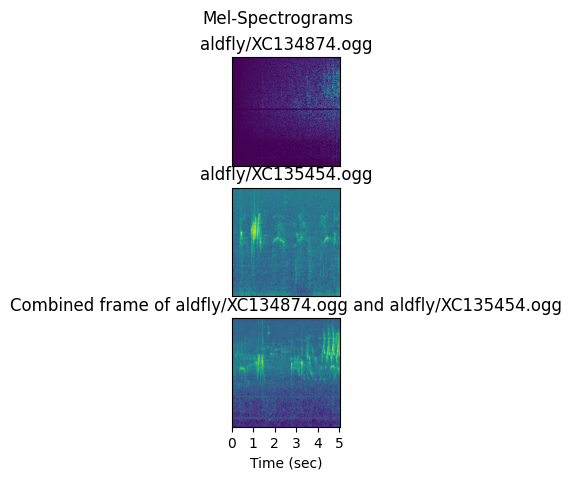

In [13]:
fft_layer = fftlayer.FFT(freq_mask_param=50, time_mask_param=None, gauss_noise_param=None, reduce_db_param=None, do_freq_fade=False, do_time_fade=True, freq_drop_rate=.5)
sample_fft0 = fft_layer(sample_audio0[None], training=True)[0]
sample_fft1 = fft_layer(sample_audio1)
sample_combined = fft_layer(sample_framed)
fig, axs = plt.subplots(3, 1)
fig.suptitle("Mel-Spectrograms")
axs[0].imshow(tf.transpose(sample_fft0[:299, :, 0]))
axs[0].set_xticks([])
axs[0].set_title(sample_fn0)
axs[1].imshow(tf.transpose(sample_fft1[:299, :, 0]))
axs[1].set_xticks([])
axs[1].set_title(sample_fn1)
axs[2].imshow(tf.transpose(sample_combined[0, :, :, 0]))
axs[2].set_title(f'Combined frame of {sample_fn0} and {sample_fn1}');
axs[2].set_xlabel('Time (sec)')
axs[2].set_xticks(ticks=range(0, sample_combined.shape[1]+1, int(1/fft_layer.stride_sec)),
               labels=range(0, 5+1))
for ax in axs:
    ax.invert_yaxis()
    # ax.set_ylabel('Frequency')
    # select_freqs = list(range(0, sample_max_freq+1, 2000))
    # select_ticks = [int(sample_combined.shape[2]*f/sample_max_freq) for f in select_freqs]
    ax.set_yticks(ticks=[], labels=[]);

# Training setup
- Preprocessing pipelines (`audio_datasets`) into single train/validation set
- Callbacks for training

In [14]:
fold_dict = metadata.get_folds()
files_for_combining = data.get_train_filenames_per_index(fold_dict['train'], metadata.competition_classes)
filename_datasets = {k: tf.data.Dataset.from_tensor_slices((fold_dict[k].full_path.to_numpy(),
                                                            fold_dict[k].primary_index.to_numpy()))
                     for k in ['train', 'valid']}
audio_datasets_raw = {
    'train': filename_datasets['train'].shuffle(len(filename_datasets['train']), reshuffle_each_iteration=True)
                                       .map(lambda x, y: (preprocessing.load_audio_augment(x), y), num_parallel_calls=tuning.num_parallel)
    ,
    'valid': filename_datasets['valid'].map(lambda x, y: (preprocessing.load_audio(x), y), num_parallel_calls=tuning.num_parallel)
}
audio_datasets = {
    'train': audio_datasets_raw['train']# .map(preprocessing.shift_audio)
                                        .map(lambda x, y: preprocessing.combine_recordings(x, y, files_for_combining), num_parallel_calls=tuning.num_parallel)
                                        .map(preprocessing.frame_audio, num_parallel_calls=tuning.num_parallel)
    ,
    'valid': audio_datasets_raw['valid'].map(preprocessing.frame_audio, num_parallel_calls=tuning.num_parallel),
}

/mnt/ebs/birdclef/birddata/data.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[keep_rows]


In [15]:
stop_early_peak = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)
stop_early_peak_4 = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', min_delta=0.001, patience=4, verbose=1, restore_best_weights=True)
stop_poor_start = callbacks.EarlyStoppingPoorStart(monitor='val_sparse_categorical_accuracy', mode='max', baseline=2/metadata.num_classes, verbose=1)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', mode='max', factor=.5, patience=3, verbose=1, min_delta=.001)

# https://www.tensorflow.org/tutorials/keras/save_and_load
def checkpoint(modelid, save_freq):
    return tf.keras.callbacks.ModelCheckpoint(filepath='../birdclef-checkpoints/checkpoint_'+ modelid + '_{epoch:04d}.keras',
                                              verbose=1,
                                              save_freq=save_freq)

# Training
- With hard-coded hyperparameters
- With tuning of hyperparmaters

In [16]:
class_weight = None# fold_dict['class_weight']
batch_size = 98*2

In [17]:
spec_model = spectrogram_model.setup_model(metadata.num_classes)

WEIGHTS None
CALL False


In [18]:
audio_stats = None

In [19]:
spec_best_model = tuning.build_model_hyperparameters(spectrogram_model.setup_model,
                                                     metadata.num_classes,
                                                     audio_stats,
                                                     datasets=audio_datasets,
                                                     class_weight=class_weight,
                                                     callbacks=[stop_early_peak, stop_poor_start, plateau],
                                                     batch_size=batch_size)

Trial 90 Complete [06h 54m 52s]
val_sparse_categorical_accuracy: 0.6647164821624756

Best val_sparse_categorical_accuracy So Far: 0.7142214179039001
Total elapsed time: 7d 10h 21m 14s
Results summary
Results in ../birdclef-tune/spec_model/birdclef
Showing 10 best trials
Objective(name="val_sparse_categorical_accuracy", direction="max")

Trial 0050 summary
Hyperparameters:
learning_rate: 0.0003740434344477363
time_mask_param: 150
freq_mask_param: 150
reduce_db_param: 0.5
tuner/epochs: 60
tuner/initial_epoch: 20
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0048
Score: 0.7142214179039001

Trial 0082 summary
Hyperparameters:
learning_rate: 0.00021113776745352607
time_mask_param: 290
freq_mask_param: 150
reduce_db_param: 0.5
tuner/epochs: 60
tuner/initial_epoch: 20
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0079
Score: 0.6944194436073303

Trial 0051 summary
Hyperparameters:
learning_rate: 0.0002322515441988787
time_mask_param: 150
freq_mask_param: 150
reduce_db_param: 0.5
tuner/epoc

In [20]:
initial_epoch = 0
if initial_epoch > 0:
    checkpoint_path = '../birdclef-checkpoints/checkpoint_'+ spec_model.name+"TUNE" + f'_{initial_epoch:04d}.ckpt'
    print("Loading checkpoint:", checkpoint_path)
    spec_best_model.load_weights(checkpoint_path)

In [21]:
spec_best_history = spec_best_model.fit(audio_datasets['train'].padded_batch(batch_size).prefetch(2),
                                        validation_data=audio_datasets['valid'].prefetch(2),
                                        epochs=80,
                                        # callbacks=[plateau, stop_early_peak, checkpoint(spec_model.name+"TUNE", 100)],
                                        callbacks=[plateau, stop_early_peak,],
                                        class_weight=class_weight,
                                        initial_epoch=initial_epoch)
spec_val_acc_per_epoch2 = spec_best_history.history['val_sparse_categorical_accuracy']
spec_best_epoch = spec_val_acc_per_epoch2.index(max(spec_val_acc_per_epoch2)) + 1
print('Best epoch: %d' % (spec_best_epoch,))

# spec_best_model_final = tuner.hypermodel.build(spec_best_hps)
# spec_best_model_final.fit(pre_fft_datasets[0].batch(batch_size), validation_data=pre_fft_datasets[1].batch(batch_size), epochs=best_epoch2)

Epoch 1/80
CALL False
CALL True
CALL True
98/98 [==============================] - 439s 4s/step - loss: 4.9979 - sparse_categorical_accuracy: 0.0552 - val_loss: 6.8213 - val_sparse_categorical_accuracy: 0.0302 - lr: 3.7404e-04
Epoch 2/80
98/98 [==============================] - 418s 4s/step - loss: 3.7226 - sparse_categorical_accuracy: 0.2065 - val_loss: 4.5215 - val_sparse_categorical_accuracy: 0.1413 - lr: 3.7404e-04
Epoch 3/80
98/98 [==============================] - 416s 4s/step - loss: 2.9021 - sparse_categorical_accuracy: 0.3588 - val_loss: 3.3344 - val_sparse_categorical_accuracy: 0.2831 - lr: 3.7404e-04
Epoch 4/80
98/98 [==============================] - 422s 4s/step - loss: 2.5202 - sparse_categorical_accuracy: 0.4306 - val_loss: 3.2040 - val_sparse_categorical_accuracy: 0.3195 - lr: 3.7404e-04
Epoch 5/80
98/98 [==============================] - 414s 4s/step - loss: 2.2482 - sparse_categorical_accuracy: 0.4926 - val_loss: 2.8039 - val_sparse_categorical_accuracy: 0.3879 - lr: 

In [22]:
spec_model_filename = f'../birdclef-checkpoints/{spec_model.name}_TUNE.keras'

In [23]:
spec_best_model.save_weights(spec_model_filename)